## Motivation
This notebook will be used and modified to debug sputter machine leak results.

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import random
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif')
import multiprocessing
import logging
from numba import jit
np.set_printoptions(precision=3, suppress=True)
# for dynamic time warping
from dtaidistance import dtw
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
# for clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from scipy.stats import entropy
from sklearn.manifold import TSNE 

## Functions to read and process data

In [3]:
def cut_cycles_index(cycle_id, cycle_data, time_stamp, cycle_sum):
    cycle_data = cycle_data[cycle_data > 0]
    time_stamp = time_stamp[cycle_data > 0]
    cycle_data = cycle_data[:-5]
    time_stamp = time_stamp[:-5]
    if (len(cycle_data) > 20 and np.min(cycle_data) < 1e-3) and np.sum(cycle_data)/float(len(cycle_data)) > cycle_sum:
        cycle_data = np.log10(cycle_data)
        cycle = pd.DataFrame({"data": cycle_data, "time_stamp": time_stamp})
        cycle['cycle_id'] = cycle_id
        return cycle
    else:
        return None


def get_cycles_for_station(open_close_data, stn_pressure, date_time,
                           cycle_sum=1e-4, index_skip=1):
    # change in the SlotValve_opened indicates a change in cycle
    indices = list(open_close_data[(open_close_data.diff() != 0)].index)
    indices.append(len(open_close_data))
    cycles = []
    for i in range(1, len(indices)-index_skip, index_skip):
        cycle = cut_cycles_index(
            i, np.array(stn_pressure[indices[i]:indices[i+index_skip]]),
            np.array(date_time[indices[i]:indices[i+index_skip]]), cycle_sum)
        if cycle is not None:
            cycles.append(cycle)
    return cycles

#### Functions for leak clustering

In [4]:
def compute_dbscan_clusters(ds, multiplier=1., min_samples=50, n_neighbors=30):
    knee_point = 0.0
    while knee_point < 1e-2:
        nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
        neighbors = nearest_neighbors.fit(ds)
        distances, indices = neighbors.kneighbors(ds)
        distances = np.sort(distances[:, (n_neighbors-1)], axis=0)

        i = np.arange(len(distances[:int(len(distances)*0.99)]))
        knee = KneeLocator(i, distances[:int(len(distances)*0.99)],
                           S=1, curve='convex', direction='increasing',
                           interp_method='polynomial')

        knee_point = distances[knee.knee]
        print(knee_point, n_neighbors)
        if len(knee_point.shape) > 0:
            knee_point = 0.
        n_neighbors = n_neighbors+10
        if n_neighbors >= 200:
            knee_point = 0.1
            break

    clustering = DBSCAN(eps=knee_point*multiplier,
                        min_samples=min_samples, n_jobs=2).fit(ds)
    return clustering.labels_, knee

In [5]:
def compute_dtw_matrix(time_series_data):
    ds = dtw.distance_matrix_fast(time_series_data, window=5)
    for i in range(ds.shape[0]):
        for j in range(ds.shape[1]):
            if i == j:
                ds[i][j] = 0.
            if ds[i][j] == np.Inf:
                ds[i][j] = ds[j][i]
    return ds

def remove_outliers_cycles(cycles):
    time_series_data = [np.array(cycle.data) for cycle in cycles]
    ds = compute_dtw_matrix(time_series_data)
    std_clf = make_pipeline(StandardScaler(), PCA(n_components=0.99))
    ret = std_clf.fit(ds)
    X_pca = ret.transform(ds)
    if X_pca.shape[1] < 3:
        std_clf = make_pipeline(StandardScaler(), PCA(n_components=3))
        ret = std_clf.fit(ds)
        X_pca = ret.transform(ds)

    clustering_labels, knee = compute_dbscan_clusters(X_pca, 1.25, 30, 50)
    cluster_counts = np.unique(clustering_labels, return_counts=True)
    index = np.argmax(cluster_counts[1])
    max_cluster = cluster_counts[0][index]
    filtered_cycles = []
    # just remove the outliers and nothing else
    if max_cluster != -1:
        filtered_cycles = [cycle for label, cycle in zip(
            clustering_labels, cycles) if label != -1]
    return filtered_cycles

#### Constants
Machine, station and time ranges

In [6]:
machine = "SV708"
station = "Stn16"
station_type = "process"
cycle_sum = 1e-7 if station_type == "non_process" else 1e-4
index_skip = 1

year = 2021
month = 9
day = 17
hour = 6
minute = 0

#### Read baseline cycles

In [7]:
pq_drive = f"Y:"
model_path = f"{pq_drive}{os.path.sep}model_data"
model_stn_path = f"{model_path}{os.path.sep}machine={machine}{os.path.sep}station={station}"
test_folder = f"{pq_drive}{os.path.sep}data{os.path.sep}"
model_stn_path, test_folder

model_data = pd.read_parquet(model_stn_path)
count_baseline = len(model_data.cycle_id.unique())
print(f"Number of baseline cycles {count_baseline}")
print(f"Baseline created between {model_data.time_stamp.min()} and "
 f"{model_data.time_stamp.max()}")

Number of baseline cycles 770
Baseline created between 2021-09-16 12:00:07.398000 and 2021-09-16 12:59:51.226000


## Plot cycles between baseline creation and test data
Between baseline creation and the test time ranges

In [8]:
begin_ts = datetime.strptime(
    f"{year}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}:00",
    '%Y-%m-%d %H:%M:%S')

In [9]:
df_list = []
ts_begin = model_data.time_stamp.min().strftime('%Y-%m-%d %H:%M:00')
ts_begin = datetime.strptime(ts_begin, '%Y-%m-%d %H:%M:%S')
ts_end = begin_ts
print(ts_begin, ts_end)

while ts_begin <= ts_end:
    date = f"{ts_begin.year}-{ts_begin.month:02d}-{ts_begin.day:02d}"
    hour_of_day = f"{ts_begin.hour}"
    data_path = f'{test_folder}machine={machine}{os.path.sep}Date={date}{os.path.sep}hour_of_day={hour_of_day}'
    print(data_path)
    if os.path.isdir(data_path) is False:
        ts_begin = ts_begin+timedelta(hours=1)
        continue
    try:
        df = pd.read_parquet(data_path, columns=[
            station, f'{station}SlotValve_opened', "DateTime"])
        df_list.append(df)
        ts_begin = ts_begin+timedelta(hours=1)
    except Exception as ex:
        print(ex)
        ts_begin = ts_begin+timedelta(hours=1)
        continue
   

2021-09-16 12:00:00 2021-09-17 06:00:00
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=12
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=13
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=14
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=15
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=16
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=17
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=18
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=19
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=20
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=21
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=22
Y:\data\machine=SV708\Date=2021-09-16\hour_of_day=23
Y:\data\machine=SV708\Date=2021-09-17\hour_of_day=0
Y:\data\machine=SV708\Date=2021-09-17\hour_of_day=1
Y:\data\machine=SV708\Date=2021-09-17\hour_of_day=2
Y:\data\machine=SV708\Date=2021-09-17\hour_of_day=3
Y:\data\machine=SV708\Date=2021-09-17\hour_of_day=4
Y:\data\machine=SV708\Date=2021-09-17\hour_of_day=5
Y:\data\mach

In [10]:
all_data = pd.concat(df_list)
ts_begin = model_data.time_stamp.min().strftime('%Y-%m-%d %H:%M:%S')
all_data.sort_values(by=['DateTime'], axis=0, inplace=True)
all_data.reset_index(inplace=True, drop=True)
all_data.shape

(2137903, 3)

In [11]:
all_data.DateTime.min(), all_data.DateTime.max()

(Timestamp('2021-09-16 12:00:00.038000'),
 Timestamp('2021-09-17 06:59:59.993000'))

#### Visualize a few cycles

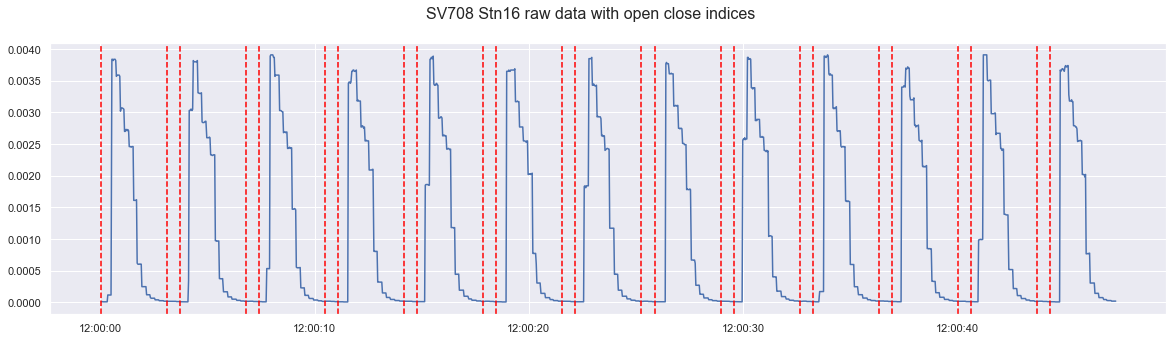

In [12]:
open_close_data = all_data[f"{station}SlotValve_opened"]
indices = list(open_close_data[(open_close_data.diff() != 0)].index)
indices.append(len(open_close_data))

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
fig.suptitle(f"{machine} {station} raw data with open close indices", fontsize=16)
plt.plot(all_data.DateTime[:indices[25]], all_data[f"{station}"][:indices[25]]);
for xc in indices[:25]:
    plt.axvline(x=all_data.DateTime.iloc[xc], color="red", linestyle = "--")

#### Histogram of slot valve open close times

In [13]:
# time_deltas = all_data.DateTime.iloc[indices[:-1]].diff()
# time_deltas = time_deltas.dropna().reset_index(drop=True)
# time_deltas = time_deltas.apply(lambda x: x.microseconds/1000)

# print(np.quantile(time_deltas, q=[0.1, 0.25, 0.5, 0.75, 1.0]))
# time_deltas.hist();

#### Visualize all cycles

In [14]:
%%time
all_cycles = get_cycles_for_station(all_data[f'{station}SlotValve_opened'], all_data[station],
    all_data["DateTime"], cycle_sum, index_skip =index_skip)
print(f"Total number of cycles {len(all_cycles)}")

Total number of cycles 17592
Wall time: 27.7 s


In [15]:
data =  pd.concat(all_cycles)
data['station'] = station
data['machine'] = machine
data.reset_index(inplace=True, drop=True)
data.time_stamp.min(), data.time_stamp.max()

(Timestamp('2021-09-16 12:00:03.718000'),
 Timestamp('2021-09-17 06:59:59.843000'))

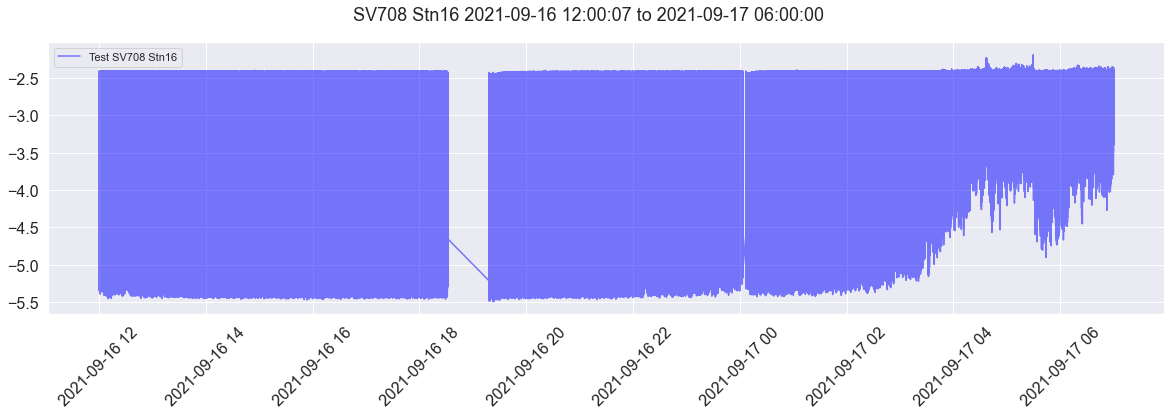

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45)
fig.suptitle(f"{machine} {station} {ts_begin} to {ts_end}", fontsize=18)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
plt.plot(data.time_stamp, data.data, color="blue",
         label=f"Test {machine} {station}", alpha=0.5)
#ax.set_ylim([-6.5, -2.75])
ax.legend();

## Compare baseline and test data only
You cannot directly do conveyor leak detection before fixing the baseline creation part which must also include the index_skip =2 part

In [17]:
# hour = 12
test_data_path = (f'{test_folder}machine={machine}{os.path.sep}'
                  f'Date={year}-{month:02}-{day:02}{os.path.sep}'
                  f'hour_of_day={hour}')
if os.path.isdir(test_data_path) is False:
    print(f"No data available for {test_data_path}")
else:
    print(test_data_path)


Y:\data\machine=SV708\Date=2021-09-17\hour_of_day=6


In [18]:
df_test = pd.read_parquet(test_data_path,columns=[
                   station, f'{station}SlotValve_opened', "DateTime"])
df_test.sort_values(by=['DateTime'], axis=0, inplace=True)
df_test.reset_index(inplace=True, drop=True)

In [19]:
%%time
cycles = get_cycles_for_station(df_test[f'{station}SlotValve_opened'], df_test[station],
    df_test["DateTime"], cycle_sum, index_skip = index_skip)
count_test = len(cycles)
print(f"Number of test cycles are {count_test}")


Number of test cycles are 974
Wall time: 1.31 s


In [20]:
filtered_cycles = remove_outliers_cycles(cycles)
print(f"Number of test cycles after filtering {len(filtered_cycles)}")
if len(filtered_cycles) == 0:
    filtered_cycles = cycles

15.928548945138658 50
Number of test cycles after filtering 965


In [21]:
# cycle_sums = [np.sum(10**(cycle.data))/len(cycle.data)
#               for cycle in filtered_cycles]
# np.mean(cycle_sums)

In [22]:
test_data =  pd.concat(filtered_cycles)
test_data['station'] = station
test_data['machine'] = machine
test_data.reset_index(inplace=True, drop=True)
test_data.time_stamp.min(), test_data.time_stamp.max()

(Timestamp('2021-09-17 06:00:02.118000'),
 Timestamp('2021-09-17 06:59:58.253000'))

In [23]:
# if len(test_data.cycle_id.unique()) >700:
#     rand_cycles = list(np.random.choice(test_data.cycle_id.unique(),size=700, replace=False ))

#     test_data = test_data.loc[test_data.cycle_id.isin(rand_cycles)]
#     test_data.sort_values(by=['cycle_id', 'time_stamp'], inplace=True)
#     test_data.reset_index(inplace=True, drop=False)

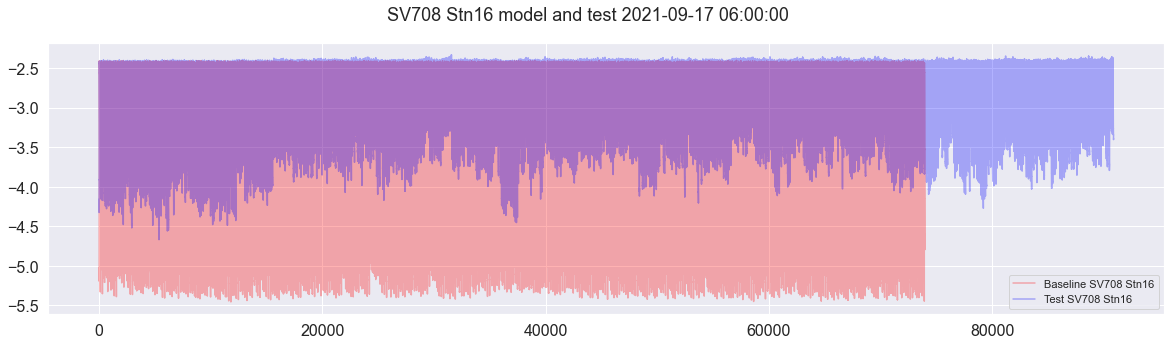

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.suptitle(f"{machine} {station} model and test {year}-{month:02d}-{day:02d} {hour:02d}:00:00",
             fontsize=18)

plt.plot(model_data[model_data.cycle_id.isin(list(model_data.cycle_id.unique())[
         :])].data, color="red", label=f"Baseline {machine} {station}", alpha=0.3)
plt.plot(test_data[test_data.cycle_id.isin(list(test_data.cycle_id.unique())[
         :])].data, color="blue", label=f"Test {machine} {station}", alpha=0.3)
ax.legend()
#ax.set_ylim([-6.5, -2.75])
ax.legend();

### Clustering
Verify and see if the results match DB

In [25]:
time_series_data = []
actual_label = []
min_cycles = []
for cycle_id, group in test_data.groupby("cycle_id"):
    pressure_cycle = np.array(group.data)
    time_series_data.append(pressure_cycle)
    actual_label.append("test_set")
    min_cycles.append(10**np.min(pressure_cycle))

for cycle_id, group in model_data.groupby("cycle_id"):
    pressure_cycle = np.array(group.data)
    time_series_data.append(pressure_cycle)
    actual_label.append("baseline")
    min_cycles.append(10**np.min(pressure_cycle))

len(time_series_data)

1735

In [26]:
def interpret_cluster_results(actual_labels, clustering_labels, min_cycles):

    result = pd.DataFrame({"actual_label": actual_labels,
                           "cluster_label": clustering_labels,
                           "min_cycle": min_cycles})

    avg_test = result[(result.actual_label == "test_set")].min_cycle.mean()

    avg_baseline = result[(result.actual_label == "baseline")].min_cycle.mean()
    #result = result[result.cluster_label != -1]
    labels_set1 = list(
        result[result.actual_label == "test_set"].cluster_label.value_counts
        (normalize=True).index)
    counts_set1 = list(
        result[result.actual_label == "test_set"].cluster_label.value_counts(
            normalize=True))
    entropy_set1 = entropy(counts_set1)
    labels_set2 = list(
        result[result.actual_label == "baseline"].cluster_label.value_counts(
            normalize=True).index)
    counts_set2 = list(
        result[result.actual_label == "baseline"].cluster_label.value_counts(
            normalize=True))

    if entropy_set1 == 0.:
        prob_stability = 1.0
    else:
        prob_stability = 1. - entropy_set1/np.log(len(labels_set1))

    diff_labels = set(labels_set1).symmetric_difference(set(labels_set2))
    if len(diff_labels) == 0:
        return "sensor_issue", round((1. - prob_stability), 4), avg_test, avg_baseline
    else:
        cluster_distribution = {}
        for index, label in enumerate(labels_set1):
            cluster_distribution[label] = [counts_set1[index]]

        for index, label in enumerate(labels_set2):
            if label in cluster_distribution:
                cluster_distribution[label].append(counts_set2[index])
            else:
                cluster_distribution[label] = [counts_set2[index]]

        for cluster_label in cluster_distribution.keys():
            normalized_perc = cluster_distribution[cluster_label]
            normalized_perc.sort()
            common_cluster = False

            if cluster_label != -1 and len(normalized_perc) == 2:
                if normalized_perc[0] > 0.2 and \
                        normalized_perc[0]*100./(
                        normalized_perc[0]+normalized_perc[1]) > 15.:
                    return "sensor_issue", round((1. - prob_stability), 4), avg_test, avg_baseline
                    common_cluster = True
                    break

        if common_cluster is False:
            return "leak", round(prob_stability, 4), avg_test, avg_baseline

In [27]:
@jit(nopython=True)
def feature_matrix(time_series_data, process_type, parameter="min"):
    feats = np.zeros((len(time_series_data), 2))
    if parameter == "conveyor":
        feats = np.zeros((len(time_series_data), 4))

    for i, x in enumerate(time_series_data):
        max_rise = 1 if np.argmax(np.diff(x)) == 0 else np.argmax(np.diff(x))
        if parameter == "min":
            feats[i][0] = np.min(x)
            if process_type == "non_process":
                feats[i][1] = np.mean(x[-len(x)//5:])
            else:
                feats[i][1] = np.mean(x[:max_rise])
        elif parameter == "length":
            feats[i][0] = np.max(x) - np.min(x)
            feats[i][1] = np.mean(np.diff(x))
        else:
            # perform check for conveyor leaks. This is beta
            # check for variance in the first and last portions of the cycles
            feats[i][0] = np.std(x[:max_rise])
            if max_rise == 1:
                feats[i][1] = 0
            else:
                feats[i][1] = np.sum(np.diff(x[:max_rise]))
            feats[i][2] = np.std(x[-len(x)//5:])
            feats[i][3] = np.sum(np.diff(x[-len(x)//5:]))

    return feats

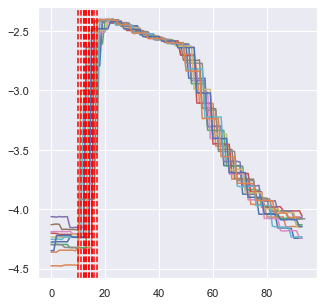

In [28]:
# the point where the pressure jumps to the maximum
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
max_rise = []
last_few = []
for x in time_series_data[12:24]:
    max_rise.append(np.argmax(np.diff(x)))
    last_few.append(3*len(x)//4)
    ax.plot(x)
if station_type =="process":
    for xc in max_rise:
        plt.axvline(x=xc, color="red", linestyle="--")
else:
    for xc in last_few:
        plt.axvline(x=xc, color="blue", linestyle="--")

In [29]:
def get_leak_results(actual_labels, time_series_data, min_cycles, process_type):
    """
    Lets see the rules here: -
    a. For a process station only min point rise is a leak.
    b. If both min and max points rise simulatneously, not a leak for both
    process and non process.
    c. For non process min and max are all leaks.

    Solution.
    a. In process station if a min point rise is observed, check if
    simulatneous rise occurs.
    b. In non process station, if sensor issue, the check for max point
    rise as well. Not if simultaneous rise occurs then it is covered
    by min point raise itself.
    """
    feats = feature_matrix(time_series_data, process_type, parameter="min")
    clustering_labels, knee = compute_dbscan_clusters(feats, 1.25, 30, 50)

    # Note that a pressure rise implies the average value of the
    # the test cycles are greater than the baseline.
    diag_final = None
    prob_final = None
    diag_min, prob_min, avg_test, avg_baseline = interpret_cluster_results(
        actual_labels, clustering_labels, min_cycles)

    if (diag_min == 'sensor_issue' and process_type == "non_process") or\
            (diag_min == 'leak' and prob_min > 0.2):
        # check for simulataneous min and max rise together
        print(f"{diag_min} {prob_min}")
        print("Check rules for leak again for drift and max rise.")

        feats = feature_matrix(time_series_data,process_type, parameter="length")
        clustering_labels, knee = compute_dbscan_clusters(feats, 1.25, 30, 50)

        diag_len, prob_len, avg_test, avg_baseline = interpret_cluster_results(
            actual_labels, clustering_labels, min_cycles)
        
        if diag_min == 'leak' and diag_len == "sensor_issue":
            diag_final, prob_final = "drift", prob_min
        else:
            diag_final, prob_final = diag_len, prob_len
    else:
        diag_final, prob_final = diag_min, prob_min

    if diag_final == 'leak' and avg_test < avg_baseline:
            print(
                ("Pressure has become better. Baseline invalid?"
                 f"{avg_test}, {avg_baseline}"))
            return "pressure_improve", prob_min, avg_test, avg_baseline
    else:
        return diag_final, prob_final, avg_test, avg_baseline


In [30]:
diag_final, prob_final, avg_test, avg_baseline = get_leak_results(
    actual_label, time_series_data, min_cycles, station_type)

diag_final, prob_final, avg_test, avg_baseline

0.09251782376285364 50
leak 0.8266
Check rules for leak again for drift and max rise.
0.03777301992674861 50


('leak', 0.8266, 0.00018074072538860105, 5.435285714285714e-06)

## Check conveyor leak

In [ ]:
feats = feature_matrix(time_series_data, station_type, parameter="conveyor")
clustering_labels, knee = compute_dbscan_clusters(feats, 1.25, 30, 50)
diag_con, prob_con, avg_test, avg_baseline = interpret_cluster_results(
    actual_label, clustering_labels, min_cycles)
diag_con, prob_con

#### Plot DBSCAN clusters

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(feats[:, 2], feats[:, 3],
           alpha=0.75, c=clustering_labels, cmap="plasma")
ax.set_title('Cluster Plot');

## Try the old methodlogy

#### Build feature matrices

In [ ]:
@jit(nopython=True)
def compute_dist_min_points(time_series_data):
    ds_min = np.zeros((len(time_series_data), len(time_series_data)))
    for i in range(len(time_series_data)):
        for j in range(i, len(time_series_data)):
            min_dist = (
                np.min(time_series_data[i]) - np.min(time_series_data[j]))
            ds_min[i][j] = min_dist
            ds_min[j][i] = -min_dist
    return ds_min


@jit(nopython=True)
def compute_dist_series_length(time_series_data):
    ds = np.zeros((len(time_series_data), len(time_series_data)))
    for i in range(len(time_series_data)):
        for j in range(i, len(time_series_data)):
            dist = (
                (np.max(time_series_data[i]) - np.min(time_series_data[i]))
                - (np.max(time_series_data[j]) - np.min(time_series_data[j])))
            ds[i][j] = dist
            ds[j][i] = -dist
    return ds


def get_principal_comps(ds):
    std_clf = make_pipeline(StandardScaler(), PCA(n_components=0.95))
    ret = std_clf.fit(ds)
    X_pca = ret.transform(ds)
    print(X_pca.shape)
    if X_pca.shape[1] < 2:
        std_clf = make_pipeline(StandardScaler(), PCA(n_components=2))
        ret = std_clf.fit(ds)
        X_pca = ret.transform(ds)
    return X_pca



In [ ]:
ds = compute_dist_series_length(time_series_data)
X_pca = get_principal_comps(ds)
X_pca.shape

In [ ]:
clustering_labels, knee = compute_dbscan_clusters(X_pca, 1.25, 50, 11)

In [ ]:
print(np.unique(clustering_labels, return_counts=True))
diag_final, prob_final, avg_test, avg_baseline = interpret_cluster_results(
    actual_label, clustering_labels, min_cycles)
diag_final, prob_final, avg_test, avg_baseline

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_pca[:, 0], X_pca[:, 1],
           alpha=0.75, c=clustering_labels, cmap="plasma")
ax.set_title('Cluster Plot');

### Plot TSNE if necessary

In [ ]:
# tsne_model = TSNE(perplexity=40., init='pca', verbose=1, n_jobs = 4)
# new_values = tsne_model.fit_transform(ds)
# f, ax = plt.subplots(1, 1, figsize=(14, 6))
# ax.scatter(new_values[:, 0], new_values[:, 1],
#            alpha=0.75, c=clustering_labels, cmap="plasma")
# ax.set_title('TSNE Cluster Plot');

In [ ]:
machine = "SV502"
uid = "746310"
command = "sudo mount.cifs //{0}/OPCWRGTrend/{0} {0} -o username=user,password={1},vers=2.0,uid={2},ro;".format(
    machine, machine.lower(), uid)
command